## Librerías a utilizar en el proyecto 

In [1]:
#Librerias para procesar datos
import pandas as pd
from datetime import datetime
import urllib.request
import numpy as np

# Librearías de gráficas
import matplotlib.pyplot as plt
import seaborn as sns


import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
#Funciones 
def limpieza_datos(url_dataset:str, fila_final:int, columna_final:int):
    """ 
    Lee el excel y se encarga de extraer la información valiosa
    Parametros:
        url_dataset - text: dirección donde se encuentra en archivo con datos en github
        columna_final - int: la última columna que contiene datos en el archivo
        fila_final - int: la última fila que contiene datos en el archivo
    retorna: 
        DataFrame
    """ 
    df = pd.read_excel(url_dataset)
    xdf = df.iloc[15:fila_final,2:columna_final]
    xdf.iloc[0,0] = "date"
    xdf_sin_nan = xdf.dropna(how='all')
    xdf_sin_nan = xdf.dropna(axis=1)
    nuevos_nombres_columnas =  list(xdf_sin_nan.iloc[0])
    xdf_sin_nan.columns = nuevos_nombres_columnas
    xdf_sin_nan = xdf_sin_nan.reset_index(drop=True)
    xdf_sin_nan = xdf_sin_nan.drop(0)
    xdf_sin_nan = xdf_sin_nan.reset_index(drop=True)
    return xdf_sin_nan


def limpieza_datos_2023(url_dataset:str, fila_final:int, columna_final:int):
    """ 
    Lee el excel y se encarga de extraer la información valiosa
    Parametros:
        url_dataset - text: dirección donde se encuentra en archivo con datos en github
        columna_final - int: la última columna que contiene datos en el archivo
        fila_final - int: la última fila que contiene datos en el archivo
    retorna: 
        DataFrame
    """ 
    df = pd.read_excel(url_dataset)
    xdf = df.iloc[15:fila_final,2:columna_final]
    xdf.iloc[0,0] = "date"
    rows_with_nan = xdf[xdf.isna().any(axis=1)]
    if not(rows_with_nan.shape == (0,0)):
        xdf_sin_nan = xdf.dropna(how='all')
    xdf_sin_nan = xdf_sin_nan.dropna(axis=1)
    nuevos_nombres_columnas =  list(xdf_sin_nan.iloc[0])
    xdf_sin_nan.columns = nuevos_nombres_columnas
    xdf_sin_nan = xdf_sin_nan.reset_index(drop=True)
    xdf_sin_nan = xdf_sin_nan.drop(0)
    xdf_sin_nan = xdf_sin_nan.reset_index(drop=True)
    return xdf_sin_nan
    
def convert_to_datetime(column):
    """
    Cambia el tipo de dato a datatime
    """
    formats = ['%Y-%m-%dT%H:%M:%S.%f', '%Y-%m-%dT%H:%M:%S,%f']
    for fmt in formats:
        try:
            return pd.to_datetime(column, format=fmt)
        except ValueError:
            continue
    raise ValueError(f"Time data '{column}' does not match any known formats")

In [4]:
url = "https://raw.githubusercontent.com/Causil/especializacion/main/monografia/momentos_evaluativos/Momento%203/utils/funciones.py"
nombre_archivo = "funciones.py"

urllib.request.urlretrieve(url, nombre_archivo)

HTTPError: HTTP Error 404: Not Found

In [5]:
from funciones import multiple_plot, plot_roc_curve, tidy_corr_matrix, checkVIF

## Carga de los datos

In [7]:
#Enlaces de los archivos de energia_activa_2020 hasta 2024 y la información captada por sensores

urls_epm = {
    'energia_activa_2020':'https://github.com/Causil/especializacion/raw/main/monografia/momentos_evaluativos/Momento%203/datos_originales/Energia%20Activa%202020.xlsx',
    'energia_activa_2021':'https://github.com/Causil/especializacion/raw/main/monografia/momentos_evaluativos/Momento%203/datos_originales/Energia%20activa%202021.xlsx',
    'energia_activa_2022':'https://github.com/Causil/especializacion/raw/main/monografia/momentos_evaluativos/Momento%203/datos_originales/Energia%20activa%202022.xlsx',
    'energia_activa_2023':'https://github.com/Causil/especializacion/raw/main/monografia/momentos_evaluativos/Momento%203/datos_originales/Energ%C3%ADa%20Activa%202023.xlsx',
    'energia_activa_2024':'https://github.com/Causil/especializacion/raw/main/monografia/momentos_evaluativos/Momento%203/datos_originales/Energ%C3%ADa%20Activa%202024.xlsx'
}

urls_sensores = {
    'iot_calderas'        :'https://raw.githubusercontent.com/Causil/especializacion/main/monografia/momentos_evaluativos/Momento%203/datos_originales/auralac_iot_calderas.csv',
    'iot_esterilizadores' :'https://raw.githubusercontent.com/Causil/especializacion/main/monografia/momentos_evaluativos/Momento%203/datos_originales/auralac_iot_esterilizadores.csv',
    'iot_pasteurizadores' :'https://raw.githubusercontent.com/Causil/especializacion/main/monografia/momentos_evaluativos/Momento%203/datos_originales/auralac_iot_pasteurizadores.csv',
    'iot_power_meters'    :'https://raw.githubusercontent.com/Causil/especializacion/main/monografia/momentos_evaluativos/Momento%203/datos_originales/auralac_iot_power_meters.csv',
    'iot_silos'           :'https://raw.githubusercontent.com/Causil/especializacion/main/monografia/momentos_evaluativos/Momento%203/datos_originales/auralac_iot_silos.csv',
    'iot_yogurteras'      :'https://raw.githubusercontent.com/Causil/especializacion/main/monografia/momentos_evaluativos/Momento%203/datos_originales/auralac_iot_yogurteras.csv',
    'iot_power_meters_act': "/home/javier/Documentos/Javier/MiPregradoDeVida/Postgrado/especializacion/monografia/momentos_evaluativos/DesarrolloMonografia/datos_originales/Datos monografia sensores.xlsx"
}

#        Exploración inicial de los datos 

In [176]:
#Miramos la estructura inicial de un archivo
df_2023_epm = pd.read_excel('https://github.com/Causil/especializacion/raw/main/monografia/momentos_evaluativos/Momento%203/datos_originales/Energ%C3%ADa%20Activa%202023.xlsx').head()

In [177]:
df_2023_epm.info()
df_2023_epm.describe()
# Para poder tener una información y descripción clara de los datos necesitamos realizar una limpieza de los datos.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Columns: 109 entries,      Matriz Consumos de Energía Activa y Reactiva por Hora to Unnamed: 108
dtypes: float64(9), object(100)
memory usage: 4.4+ KB


,Matriz Consumos de Energía Activa y Reactiva por Hora,Unnamed: 1,Unnamed: 8,Unnamed: 12,Unnamed: 14,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cargamos los datos de los sensores

In [178]:
# Cargamos los datos de los sensores
df_iot_calderas        = pd.read_csv( urls_sensores['iot_calderas'], sep=',')
df_iot_esterilizadores = pd.read_csv( urls_sensores['iot_esterilizadores'], sep=',')
df_iot_pasteurizadores = pd.read_csv( urls_sensores['iot_pasteurizadores'], sep=',')
df_iot_power_meters    = pd.read_csv( urls_sensores['iot_power_meters'], sep=',')
df_iot_silos           = pd.read_csv( urls_sensores['iot_silos']       , sep=',')
df_iot_yogurteras      = pd.read_csv( urls_sensores['iot_yogurteras']  , sep=',')
iot_power_meters_act   = pd.read_excel( urls_sensores['iot_power_meters_act'])

## Limpieza de datos

### Limpieza de datos - origen de EPM

In [179]:
# Eliminar celdas y espacios vacios utilizando la función limpieza_datos.
energia_activa_2020 = limpieza_datos(urls_epm["energia_activa_2020"], 336, 109)
energia_activa_2021 = limpieza_datos(urls_epm["energia_activa_2021"], 381, 109)
energia_activa_2022 = limpieza_datos(urls_epm["energia_activa_2022"], 381, 109)
energia_activa_2023 = limpieza_datos(urls_epm["energia_activa_2023"], 231, 109)
energia_activa_2024 = limpieza_datos(urls_epm["energia_activa_2024"], 157, 109)

In [180]:
# Agrupamos y sumamos la información para que quede por días
df_reactiva_epm = pd.concat([energia_activa_2020, energia_activa_2021, energia_activa_2022, energia_activa_2023, energia_activa_2024]).T.groupby(level=0).sum().T
df_reactiva_epm.columns = ["activa_consumo", "activa_generación", "reactiva_capacitiva", "reactiva_inductiva", "date"]

In [181]:
#Cambiando los tipos de datos a sus datos correspondientes
df_reactiva_epm['date'] = pd.to_datetime(df_reactiva_epm['date'], format='%d/%m/%Y')
type_datos = {
    'activa_consumo': 'float16',
    'activa_generación': 'float16',
    'reactiva_capacitiva': 'float16',
    'reactiva_inductiva': 'float16'
}
df_reactiva_epm = df_reactiva_epm.astype(type_datos)

In [182]:
df_reactiva_epm


,activa_consumo,activa_generación,reactiva_capacitiva,reactiva_inductiva,date
0,4948.0,0.0,0.0,1382.0,2020-02-16
1,14400.0,0.0,0.0,7072.0,2020-02-17
2,14896.0,0.0,0.0,7640.0,2020-02-18
3,14976.0,0.0,0.0,7800.0,2020-02-19
4,16104.0,0.0,0.0,8376.0,2020-02-20
...,...,...,...,...,...
135,20096.0,0.0,0.0,11568.0,2024-05-15
136,19568.0,0.0,0.0,10744.0,2024-05-16
137,22848.0,0.0,0.0,11280.0,2024-05-17
138,17984.0,0.0,0.0,10064.0,2024-05-18


In [183]:
df_reactiva_epm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1404 entries, 0 to 139
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   activa_consumo       1404 non-null   float16       
 1   activa_generación    1404 non-null   float16       
 2   reactiva_capacitiva  1404 non-null   float16       
 3   reactiva_inductiva   1404 non-null   float16       
 4   date                 1404 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float16(4)
memory usage: 65.2 KB


In [184]:
numCols = df_reactiva_epm.select_dtypes(include = ['float16']).columns.tolist()
df_reactiva_epm[numCols].head()

,activa_consumo,activa_generación,reactiva_capacitiva,reactiva_inductiva
0,4948.0,0.0,0.0,1382.0
1,14400.0,0.0,0.0,7072.0
2,14896.0,0.0,0.0,7640.0
3,14976.0,0.0,0.0,7800.0
4,16104.0,0.0,0.0,8376.0


/home/javier/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/javier/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/javier/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/javier/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/javier/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/home/javier/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:1615: UserWarnin

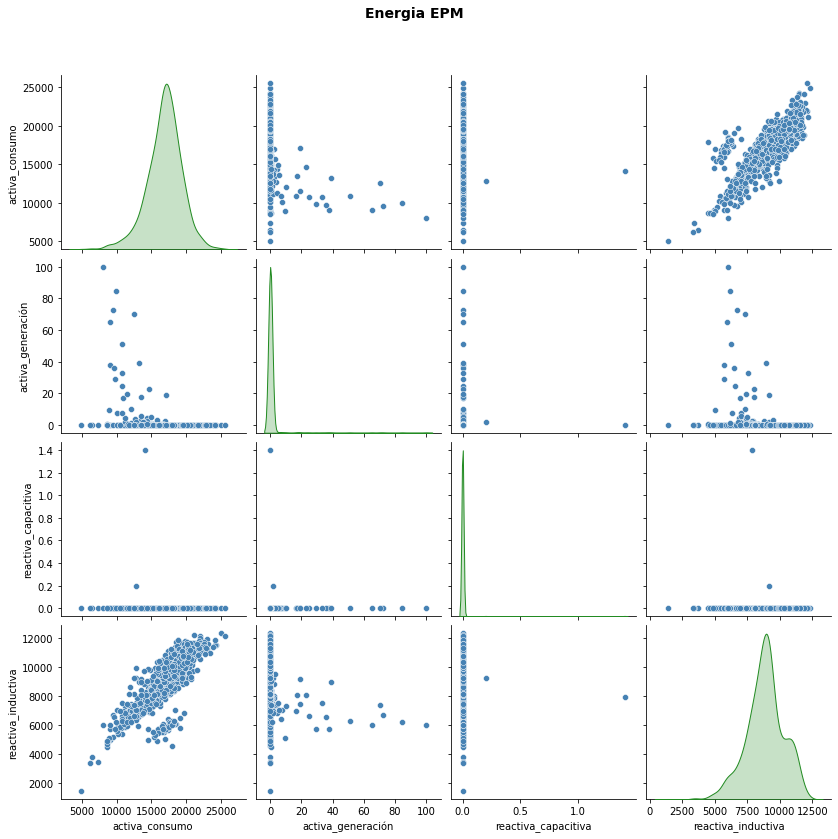

In [185]:
multiple_plot(1, df_reactiva_epm , numCols, None, 'scatterplot', 'Energia EPM',30)

In [186]:
matrizCorr = df_reactiva_epm[numCols].corr()

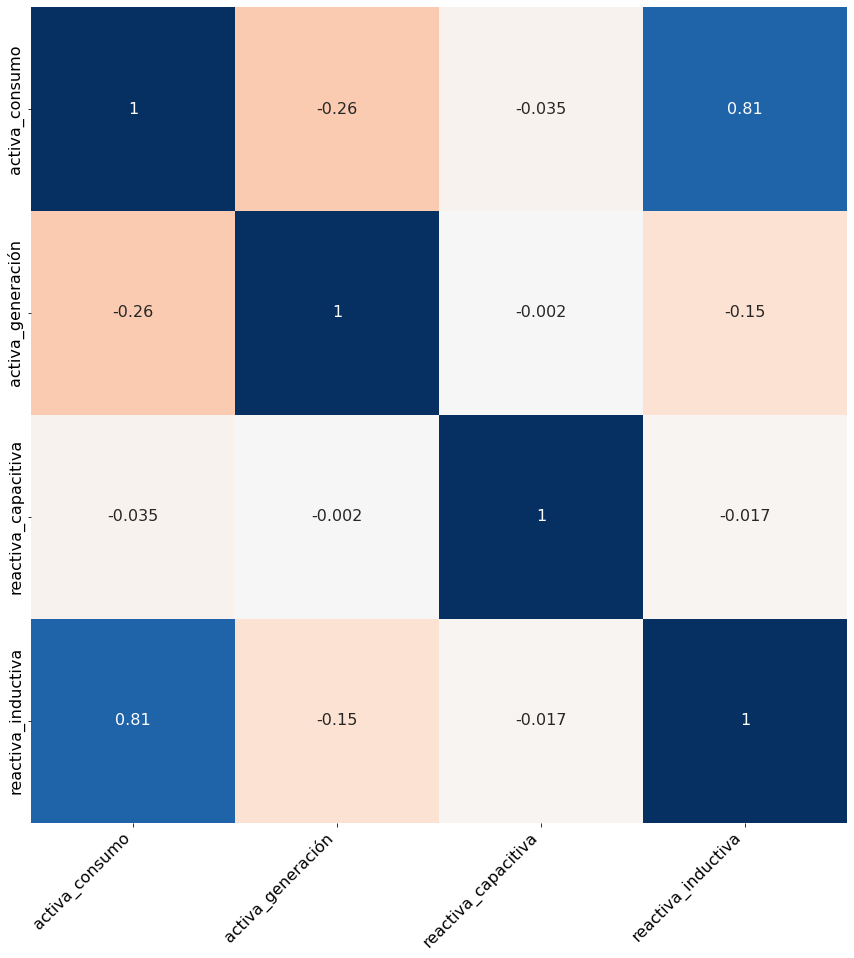

In [187]:
# Mapa de calor (Heatmap) de la matriz de correlaciones
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

sns.heatmap(
    matrizCorr,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 16},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = 'RdBu', #sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 16)

Se puede ver una relación entre las varibles energia_reactiva_inductiva y energia_activa_consumo

/tmp/ipykernel_25350/2548033958.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_reactiva_epm['activa_consumo'])
/tmp/ipykernel_25350/2548033958.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_reactiva_epm['activa_consumo'], palette='nipy_spectral')
/tmp/ipykernel_25350/2548033958.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or

Text(0.5, 0.98, 'Energía EPM')

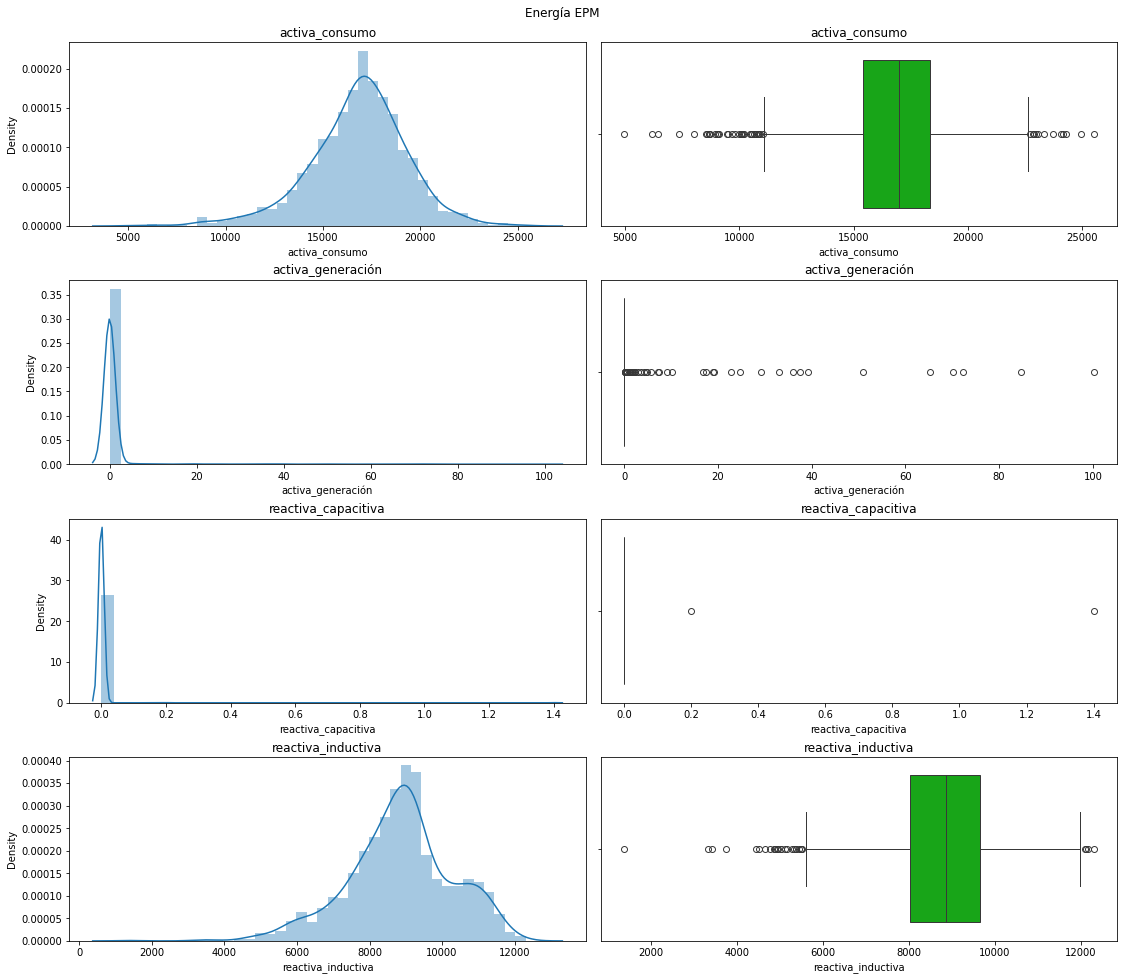

In [188]:
#
fig = plt.figure(figsize=(15.5, 13.5), layout="constrained")
spec = fig.add_gridspec(ncols=2, nrows=4)

ax0 = fig.add_subplot(spec[0, 0])
plt.title('activa_consumo')
sns.distplot(df_reactiva_epm['activa_consumo'])

ax1 = fig.add_subplot(spec[0, 1])
plt.title('activa_consumo')
sns.boxplot(x=df_reactiva_epm['activa_consumo'], palette='nipy_spectral')

ax2 = fig.add_subplot(spec[1, 0])
plt.title('activa_generación')
sns.distplot(df_reactiva_epm['activa_generación'])

ax3 = fig.add_subplot(spec[1, 1])
plt.title('activa_generación')
sns.boxplot(x=df_reactiva_epm['activa_generación'], palette='nipy_spectral')

ax4 = fig.add_subplot(spec[2, 0])
plt.title('reactiva_capacitiva')
sns.distplot(df_reactiva_epm['reactiva_capacitiva'])

ax5 = fig.add_subplot(spec[2, 1])
plt.title('reactiva_capacitiva')
sns.boxplot(x=df_reactiva_epm['reactiva_capacitiva'], palette='nipy_spectral')


ax6 = fig.add_subplot(spec[3, 0])
plt.title('reactiva_inductiva')
sns.distplot(df_reactiva_epm['reactiva_inductiva'])

ax7 = fig.add_subplot(spec[3, 1])
plt.title('reactiva_inductiva')
sns.boxplot(x=df_reactiva_epm['reactiva_inductiva'], palette='nipy_spectral')


fig.suptitle('Energía EPM')

### Datos atipicos


In [189]:
#Calculo de valores atípicos 
"""
activa_consumo
activa_generación
reactiva_capacitiva
reactiva_inductiva
"""
def atipicos(column, df):
    #Calculo de Q1 t Q3
    Q1 = np.percentile(column, 25, interpolation = 'midpoint')
    Q3 = np.percentile(column, 75, interpolation = 'midpoint')
    #Cálculo del rango intercuartil
    IQR = Q3 - Q1
    #Cálculo de valor mínimo y máximo para los valores atípicos
    VAInf = Q1 - 1.5*IQR
    VASup = Q3 + 1.5*IQR
    cantidad_atipicos_sup = df[column>VASup]
    cantidad_atipicos_inf = df[column<VAInf]
    cantidad_atipicos = len(cantidad_atipicos_sup) +len(cantidad_atipicos_inf)
    return cantidad_atipicos,VAInf, VASup
           
atp_activa_consumo = atipicos(df_reactiva_epm["activa_consumo"],df_reactiva_epm)
atp_activa_generación = atipicos(df_reactiva_epm["activa_generación"],df_reactiva_epm)
atp_reactiva_capacitiva = atipicos(df_reactiva_epm["reactiva_capacitiva"],df_reactiva_epm)
atp_reactiva_inductiva = atipicos(df_reactiva_epm["reactiva_inductiva"],df_reactiva_epm)

print(f'Valores atípicos de activa_consumo (cantidad, inf, sup): {atp_activa_consumo}')
print(f'Valores atípicos de activa_generación (cantidad, inf, sup): {atp_activa_generación}')
print(f'Valores atípicos de reactiva_capacitiva (cantidad, inf, sup): {atp_reactiva_capacitiva}')
print(f'Valores atípicos de reactiva_inductiva (cantidad, inf, sup): {atp_reactiva_inductiva}')

Valores atípicos de activa_consumo (cantidad, inf, sup): (46, 11064.0, 22712.0)
Valores atípicos de activa_generación (cantidad, inf, sup): (48, 0.0, 0.0)
Valores atípicos de reactiva_capacitiva (cantidad, inf, sup): (2, 0.0, 0.0)
Valores atípicos de reactiva_inductiva (cantidad, inf, sup): (29, 5594.0, 12106.0)


/tmp/ipykernel_25350/3377457317.py:22: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  atp_activa_consumo = atipicos(df_reactiva_epm["activa_consumo"],df_reactiva_epm)
/tmp/ipykernel_25350/3377457317.py:23: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  atp_activa_generación = atipicos(df_reactiva_epm["activa_generación"],df_reactiva_epm)
/tmp/ipykernel_25350/3377457317.py:24: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to re


Variables para calcular valores atípicos

$Q1 = \text{ perceptil 25 }\\$
$Q2 = \text{ perceptil 75 } \\$
$IQR = Q3 - Q1 $
$$
    VAInf = Q1 - 1.5*IQR,\\
    VASup = Q3 + 1.5*IQR
$$


Resumen de valores atípicos

| Columna | Cantidad | Valor infimo | Valor supremo |
|:---  |:--- |:---|:---|
| activa_consumo | 46 | 11064.0 | 22712.0 |
| activa_generación | 48 | 0.0 | 0.0 |
| reactiva_capacitiva |2 | 0.0 | 0.0 |
| reactiva_inductiva | 29 | 5594.0 | 12106.0 |


In [190]:
# Datos atipicos
cantidad_atipicos = df_reactiva_epm[df_reactiva_epm['reactiva_inductiva']>atp_activa_consumo[2]]
print(f'La cantidad de datos atípicos a eliminar son: {cantidad_atipicos}')

#data = data.drop(data[data['Concrete compressive strength']>VASup].index)

#Reiniciar el indice
#data.reset_index(drop=True, inplace=True)

La cantidad de datos atípicos a eliminar son: Empty DataFrame
Columns: [activa_consumo, activa_generación, reactiva_capacitiva, reactiva_inductiva, date]
Index: []


### Limpieza de datos proveniente de los sensores

### 

In [191]:
df_iot_power_meters.head()

,equipo,ts,corriente_a,corriente_b,corriente_c,corriente_media,distorsion_media_total,energia_activa,energia_aparente,energia_reactiva,factor_potencia,potencia_activa,potencia_aparente,potencia_reactiva,tension_media,voltaje_ab,voltaje_bc,voltaje_ca
0,pm-2000kva,2023-10-10T18:52:47.919087,23.0,25.9,23.5,24.2,159.9,240566.4,358203.8,260980.9,1.2,16.6,20.2,'-11.5,482.8,483.8,483.3,481.5
1,pm-2000kva,2023-10-10T18:52:48.918342,23.4,26.4,23.9,25.0,160.0,240566.4,358203.8,260980.9,1.2,17.1,21.0,'-12.1,482.9,483.8,483.3,481.5
2,pm-2000kva,2023-10-10T18:52:49.918697,23.4,26.3,23.6,24.5,159.7,240566.4,358203.8,260980.9,1.2,16.6,20.5,'-12,482.8,483.7,483.3,481.4
3,pm-2000kva,2023-10-10T18:52:50.918346,24.0,27.0,24.4,25.1,159.8,240566.4,358203.8,260980.9,1.2,17.1,21.0,'-12.2,482.8,483.7,483.2,481.4
4,pm-2000kva,2023-10-10T18:52:51.918629,23.0,26.0,23.5,24.1,159.7,240566.4,358203.8,260980.9,1.2,16.5,20.2,'-11.6,482.7,483.6,483.2,481.4


In [192]:
# Cambiando el tipo de dato de cada columna a su correspondiente tipo
for df_ in  [df_iot_calderas, df_iot_esterilizadores, df_iot_pasteurizadores, df_iot_power_meters, df_iot_silos, df_iot_yogurteras]:
    for column_id in range(len(df_.columns)):
        name_columns = df_.columns[column_id]
        if column_id == 1:
            df_[name_columns] = convert_to_datetime(df_[name_columns])
        elif column_id == 0:
            df_[name_columns] = df_[name_columns].astype(str)
        elif column_id == 13:
            df_[name_columns] = df_[name_columns].astype(str)            
        else :
            df_[name_columns] = pd.to_numeric(df_[name_columns], errors='coerce')

In [193]:
df_iot_power_meters.head()

,equipo,ts,corriente_a,corriente_b,corriente_c,corriente_media,distorsion_media_total,energia_activa,energia_aparente,energia_reactiva,factor_potencia,potencia_activa,potencia_aparente,potencia_reactiva,tension_media,voltaje_ab,voltaje_bc,voltaje_ca
0,pm-2000kva,2023-10-10 18:52:47.919087,23.0,25.9,23.5,24.2,159.9,240566.4,358203.8,260980.9,1.2,16.6,20.2,'-11.5,482.8,483.8,483.3,481.5
1,pm-2000kva,2023-10-10 18:52:48.918342,23.4,26.4,23.9,25.0,160.0,240566.4,358203.8,260980.9,1.2,17.1,21.0,'-12.1,482.9,483.8,483.3,481.5
2,pm-2000kva,2023-10-10 18:52:49.918697,23.4,26.3,23.6,24.5,159.7,240566.4,358203.8,260980.9,1.2,16.6,20.5,'-12,482.8,483.7,483.3,481.4
3,pm-2000kva,2023-10-10 18:52:50.918346,24.0,27.0,24.4,25.1,159.8,240566.4,358203.8,260980.9,1.2,17.1,21.0,'-12.2,482.8,483.7,483.2,481.4
4,pm-2000kva,2023-10-10 18:52:51.918629,23.0,26.0,23.5,24.1,159.7,240566.4,358203.8,260980.9,1.2,16.5,20.2,'-11.6,482.7,483.6,483.2,481.4


In [194]:
df_iot_power_meters.info()
df_iot_power_meters.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   equipo                  50 non-null     object        
 1   ts                      50 non-null     datetime64[ns]
 2   corriente_a             50 non-null     float64       
 3   corriente_b             50 non-null     float64       
 4   corriente_c             50 non-null     float64       
 5   corriente_media         50 non-null     float64       
 6   distorsion_media_total  50 non-null     float64       
 7   energia_activa          50 non-null     float64       
 8   energia_aparente        50 non-null     float64       
 9   energia_reactiva        50 non-null     float64       
 10  factor_potencia         50 non-null     float64       
 11  potencia_activa         50 non-null     float64       
 12  potencia_aparente       50 non-null     float64     

,ts,corriente_a,corriente_b,corriente_c,corriente_media,distorsion_media_total,energia_activa,energia_aparente,energia_reactiva,factor_potencia,potencia_activa,potencia_aparente,tension_media,voltaje_ab,voltaje_bc,voltaje_ca
count,50,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.0,5.000000e+01,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000
mean,2023-10-10 18:53:13.714603008,23.524000,26.530000,23.986000,24.728000,159.130000,240566.496000,358203.938000,260980.9,1.200000e+00,16.834000,20.698000,482.67000,483.570000,483.074000,481.340000
min,2023-10-10 18:52:47.919087,22.900000,25.900000,23.500000,24.100000,157.000000,240566.400000,358203.800000,260980.9,1.200000e+00,16.400000,20.200000,482.30000,483.100000,482.600000,481.000000
25%,2023-10-10 18:53:00.193612544,23.200000,26.200000,23.700000,24.500000,158.350000,240566.400000,358203.900000,260980.9,1.200000e+00,16.525000,20.500000,482.50000,483.500000,483.000000,481.200000
50%,2023-10-10 18:53:13.419066624,23.450000,26.500000,23.950000,24.700000,159.400000,240566.500000,358203.900000,260980.9,1.200000e+00,16.800000,20.700000,482.70000,483.600000,483.100000,481.400000
75%,2023-10-10 18:53:27.668234240,23.900000,26.875000,24.300000,25.000000,159.700000,240566.600000,358204.000000,260980.9,1.200000e+00,17.100000,20.900000,482.80000,483.700000,483.200000,481.500000
max,2023-10-10 18:53:39.951809,24.100000,27.200000,24.500000,25.300000,160.400000,240566.600000,358204.100000,260980.9,1.200000e+00,17.300000,21.100000,483.00000,483.800000,483.300000,481.700000
std,NaN,0.362846,0.386111,0.325771,0.337482,0.836721,0.078142,0.102798,0.0,2.242989e-16,0.298028,0.283196,0.18979,0.198206,0.187148,0.190595


In [195]:
df_iot_power_meters["potencia_reactiva"]

0     '-11.5
1     '-12.1
2       '-12
3     '-12.2
4     '-11.6
5       '-12
6     '-12.7
7     '-12.1
8     '-11.9
9     '-11.5
10    '-12.6
11    '-11.2
12    '-11.8
13      '-12
14    '-12.4
15    '-11.3
16    '-12.6
17    '-12.2
18    '-11.5
19    '-12.6
20    '-11.7
21    '-12.1
22    '-11.6
23    '-12.3
24    '-11.9
25    '-11.9
26    '-12.2
27      '-12
28    '-11.5
29      '-12
30    '-12.5
31    '-12.2
32      '-12
33    '-12.2
34    '-11.2
35    '-11.8
36    '-11.9
37    '-11.5
38    '-12.7
39    '-12.2
40    '-11.8
41    '-11.9
42    '-11.8
43      '-13
44    '-11.9
45    '-11.9
46    '-12.2
47    '-11.9
48    '-12.3
49    '-12.2
Name: potencia_reactiva, dtype: object

In [196]:
numCols_power_meters = df_iot_power_meters.select_dtypes(include = ['float64']).columns.tolist()
print(len(numCols_power_meters))
df_iot_power_meters[numCols_power_meters].head()

15


,corriente_a,corriente_b,corriente_c,corriente_media,distorsion_media_total,energia_activa,energia_aparente,energia_reactiva,factor_potencia,potencia_activa,potencia_aparente,tension_media,voltaje_ab,voltaje_bc,voltaje_ca
0,23.0,25.9,23.5,24.2,159.9,240566.4,358203.8,260980.9,1.2,16.6,20.2,482.8,483.8,483.3,481.5
1,23.4,26.4,23.9,25.0,160.0,240566.4,358203.8,260980.9,1.2,17.1,21.0,482.9,483.8,483.3,481.5
2,23.4,26.3,23.6,24.5,159.7,240566.4,358203.8,260980.9,1.2,16.6,20.5,482.8,483.7,483.3,481.4
3,24.0,27.0,24.4,25.1,159.8,240566.4,358203.8,260980.9,1.2,17.1,21.0,482.8,483.7,483.2,481.4
4,23.0,26.0,23.5,24.1,159.7,240566.4,358203.8,260980.9,1.2,16.5,20.2,482.7,483.6,483.2,481.4


/home/javier/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/javier/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/javier/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/javier/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/javier/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/javier/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: UserW

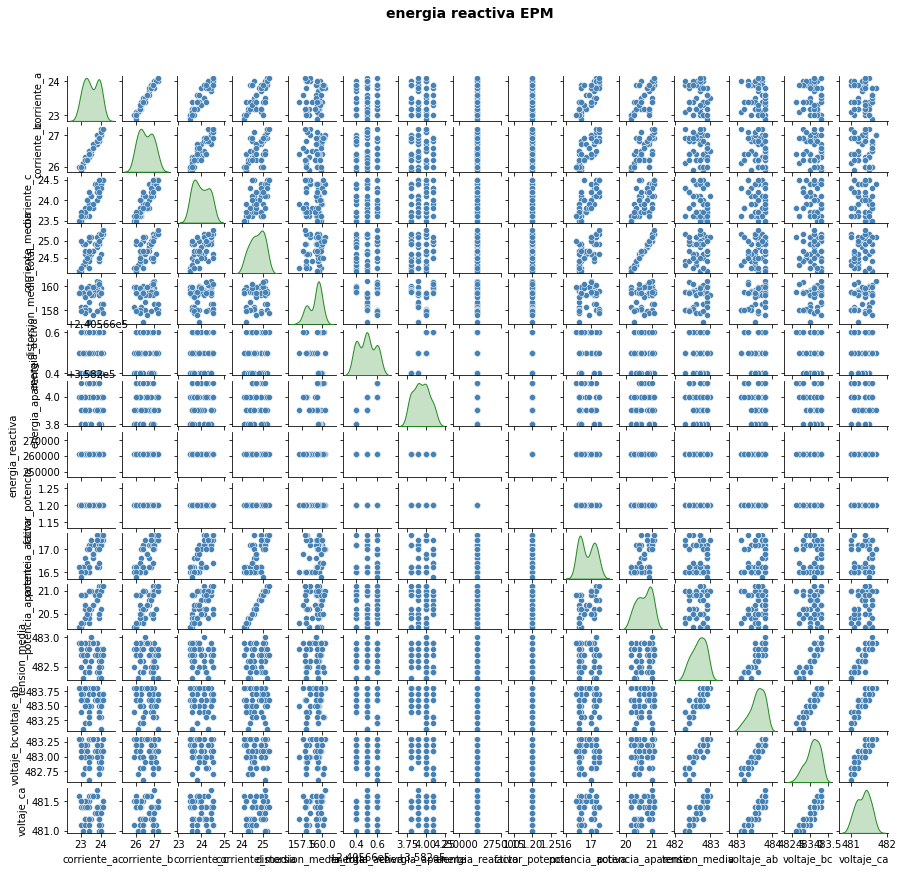

In [197]:
multiple_plot(5, df_iot_power_meters , numCols_power_meters, None, 'scatterplot', 'energia reactiva EPM',30)

matrizCorr_power_meters = df_iot_power_meters[numCols_power_meters].corr()

<Axes: >

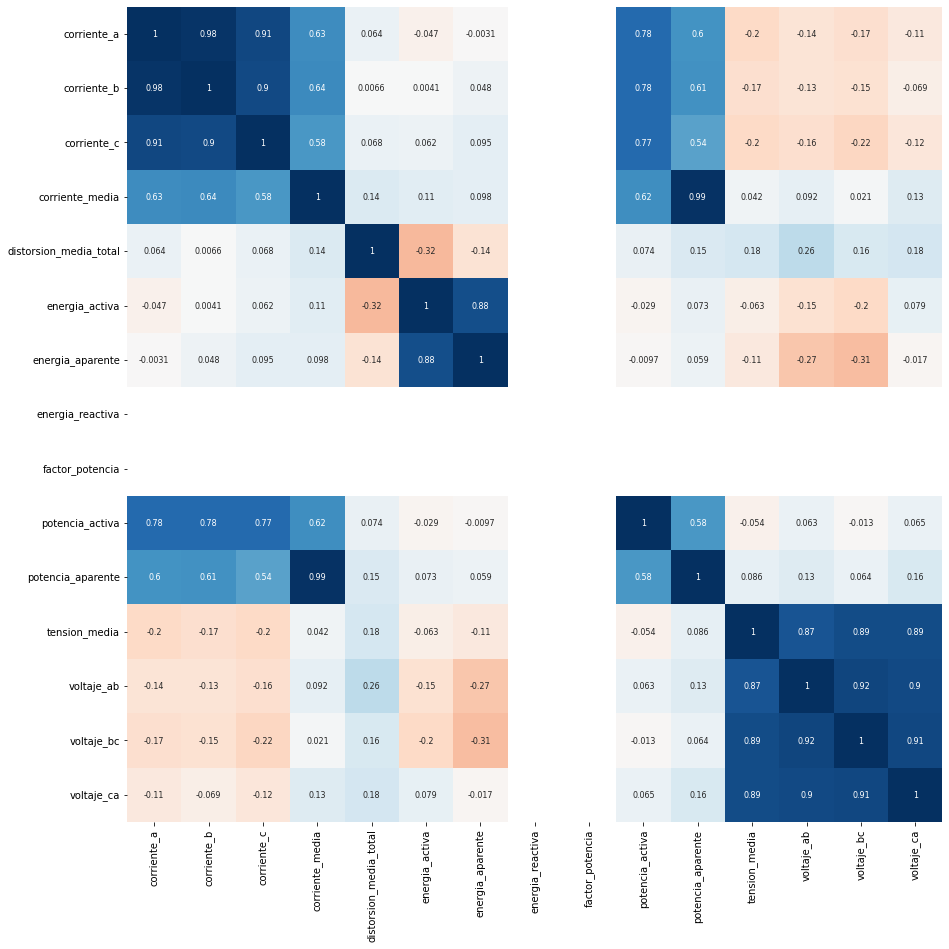

In [198]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

sns.heatmap(
    matrizCorr_power_meters,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = 'RdBu', #sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)


# Cargando datos de sensores para modelos

In [8]:
iot_power_meters_act = pd.read_excel(urls_sensores.get('iot_power_meters_act'))

In [9]:
iot_power_meters_act.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35979 entries, 0 to 35978
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    35979 non-null  datetime64[ns]
 1   hour                    35979 non-null  object        
 2   voltaje_ab              35979 non-null  float64       
 3   voltaje_bc              35979 non-null  float64       
 4   voltaje_ca              35979 non-null  float64       
 5   tension_media           35979 non-null  float64       
 6   potencia_activa         35979 non-null  float64       
 7   potencia_reactiva       35979 non-null  float64       
 8   potencia_aparente       35979 non-null  float64       
 9   factor_potencia         35979 non-null  float64       
 10  corriente_a             35978 non-null  float64       
 11  corriente_b             35978 non-null  float64       
 12  corriente_c             35978 non-null  float6

energia_total_consumida_planta = pm-2000kva + pm-1000kva + pm-300kva + pm-112kva + pm-538kwp

Energia por la que se paga: 

energia_a_pagar = pm-2000kva + pm-1000kva + pm-300kva + pm112

In [10]:
iot_power_meters_act["equipo"].unique()

array(['pm-filtro-activo', 'pm-112kva', 'pm-1000kva', 'pm-2000kva',
       'pm-538kwp', 'pm-500kva', 'pm-300kva'], dtype=object)

In [11]:
iot_power_meters_act.head()

,date,hour,voltaje_ab,voltaje_bc,voltaje_ca,tension_media,potencia_activa,potencia_reactiva,potencia_aparente,factor_potencia,corriente_a,corriente_b,corriente_c,corriente_media,distorsion_media_total,energia_activa,energia_reactiva,energia_aparente,equipo,month
0,2024-03-04,4/03/2024 11:00:00 p. m.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,131.67,129.07,139.03,0.0,0.0,0.0,0.0,0.0,pm-filtro-activo,2024-03
1,2024-03-08,8/03/2024 7:00:00 a. m.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.19,60.06,67.81,0.0,0.0,0.0,0.0,0.0,pm-filtro-activo,2024-03
2,2024-03-11,11/03/2024 5:00:00 a. m.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.21,76.67,79.93,0.0,0.0,0.0,0.0,0.0,pm-filtro-activo,2024-03
3,2024-03-12,12/03/2024 6:00:00 a. m.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,138.70,132.42,145.74,0.0,0.0,0.0,0.0,0.0,pm-filtro-activo,2024-03
4,2024-03-12,12/03/2024 4:00:00 p. m.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.83,85.23,89.90,0.0,0.0,0.0,0.0,0.0,pm-filtro-activo,2024-03


### Eliminando equipos que no le aportan a la energía reactiva

Los equipos que no le aportan a la energía reactiva son: pm-2000kva + pm-1000kva + pm-300kva + Pm-112. 

En nuestro dataset corresponden a la variable equipo y son : 
1. pm-2000kva
2. pm-1000kva
3. pm-300kva
4. pm-112kva


In [12]:
iot_power_meters_act["equipo"].unique()

array(['pm-filtro-activo', 'pm-112kva', 'pm-1000kva', 'pm-2000kva',
       'pm-538kwp', 'pm-500kva', 'pm-300kva'], dtype=object)

In [13]:
#pm-2000kva
#pm-1000kva
#pm-300kva
#pm-112kva
# Estos equipos le aportan a la energía reactiva
valores_permitidos = [
    "pm-2000kva",
    "pm-1000kva",
    "pm-300kva",
    "pm-112kva",
    "pm-538kwp"
]
df_filtrado = iot_power_meters_act.loc[iot_power_meters_act['equipo'].isin(valores_permitidos)]

In [14]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28074 entries, 3791 to 35978
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    28074 non-null  datetime64[ns]
 1   hour                    28074 non-null  object        
 2   voltaje_ab              28074 non-null  float64       
 3   voltaje_bc              28074 non-null  float64       
 4   voltaje_ca              28074 non-null  float64       
 5   tension_media           28074 non-null  float64       
 6   potencia_activa         28074 non-null  float64       
 7   potencia_reactiva       28074 non-null  float64       
 8   potencia_aparente       28074 non-null  float64       
 9   factor_potencia         28074 non-null  float64       
 10  corriente_a             28074 non-null  float64       
 11  corriente_b             28074 non-null  float64       
 12  corriente_c             28074 non-null  float64 

In [15]:
mes_10_dia_15 = df_filtrado[df_filtrado["date"] == "2023-10-15"]

In [16]:
mes_10_dia_15.info()


<class 'pandas.core.frame.DataFrame'>
Index: 72 entries, 5483 to 35404
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    72 non-null     datetime64[ns]
 1   hour                    72 non-null     object        
 2   voltaje_ab              72 non-null     float64       
 3   voltaje_bc              72 non-null     float64       
 4   voltaje_ca              72 non-null     float64       
 5   tension_media           72 non-null     float64       
 6   potencia_activa         72 non-null     float64       
 7   potencia_reactiva       72 non-null     float64       
 8   potencia_aparente       72 non-null     float64       
 9   factor_potencia         72 non-null     float64       
 10  corriente_a             72 non-null     float64       
 11  corriente_b             72 non-null     float64       
 12  corriente_c             72 non-null     float64    

In [1]:
mes_10_dia_15[mes_10_dia_15["hour"] == "15/10/2023 4:00:00 a. m."]

NameError: name 'mes_10_dia_15' is not defined

Variables a tomar un valor representativo: 
1. date
2. hour
3. month

Variables a promediar: 
1. voltaje_ab, 
2. voltaje_bc, 
3. voltaje_ca, 
4. tension_media, 
5. potencia_activa, 
6. potencia_reactiva
7. potencia_aparente	
8. factor_potencia
9. corriente_a
10. corriente_b
11. corriente_c
12. corriente_media
13. distorsion_media_total

Variables a sumar: 
1. energia_activa
2. energia_reactiva
3. energia_aparente

Pendiente consultar con el experto en negocio.

In [18]:
data_hour = df_filtrado.groupby(["date", "hour"]).agg({
 "voltaje_ab"            : "mean",
 "voltaje_bc"            : "mean",
 "voltaje_ca"            : "mean",
 "tension_media"         : "mean",
 "potencia_activa"       : "mean",
 "potencia_reactiva"     : "mean",
 "potencia_aparente"     : "mean",
 "factor_potencia"       : "mean",
 "corriente_a"           : "mean",
 "corriente_b"           : "mean",
 "corriente_c"           : "mean",
 "corriente_media"       : "mean",
 "distorsion_media_total": "mean",
 "energia_activa"        : "sum",
 "energia_reactiva"      : "sum",
 "energia_aparente"      : "sum"
}).reset_index()

In [19]:
data_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5921 entries, 0 to 5920
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    5921 non-null   datetime64[ns]
 1   hour                    5921 non-null   object        
 2   voltaje_ab              5921 non-null   float64       
 3   voltaje_bc              5921 non-null   float64       
 4   voltaje_ca              5921 non-null   float64       
 5   tension_media           5921 non-null   float64       
 6   potencia_activa         5921 non-null   float64       
 7   potencia_reactiva       5921 non-null   float64       
 8   potencia_aparente       5921 non-null   float64       
 9   factor_potencia         5921 non-null   float64       
 10  corriente_a             5921 non-null   float64       
 11  corriente_b             5921 non-null   float64       
 12  corriente_c             5921 non-null   float64 

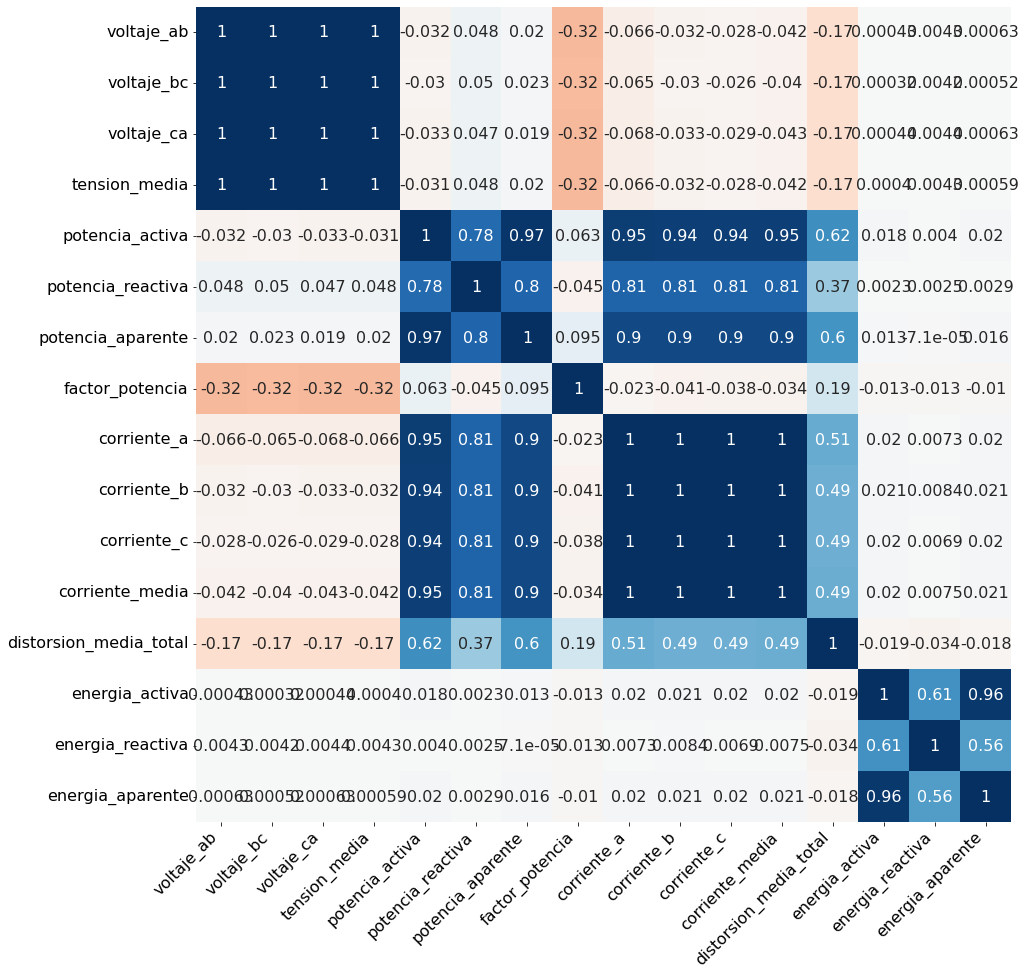

In [20]:
numCols = data_hour.select_dtypes(include = ['float64']).columns.tolist()
matrizCorr = data_hour[numCols].corr()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

sns.heatmap(
    matrizCorr,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 16},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = 'RdBu', #sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 16)


In [21]:
data_hour[data_hour["date"] == "2023-10-10"]["energia_activa"].sum()

4336.400000000001

In [22]:
data_day = df_filtrado.groupby(["date"]).agg({
 "voltaje_ab"            : "mean",
 "voltaje_bc"            : "mean",
 "voltaje_ca"            : "mean",
 "tension_media"         : "mean",
 "potencia_activa"       : "mean",
 "potencia_reactiva"     : "mean",
 "potencia_aparente"     : "mean",
 "factor_potencia"       : "mean",
 "corriente_a"           : "mean",
 "corriente_b"           : "mean",
 "corriente_c"           : "mean",
 "corriente_media"       : "mean",
 "distorsion_media_total": "mean",
 "energia_activa"        : "sum",
 "energia_reactiva"      : "sum",
 "energia_aparente"      : "sum"
}).reset_index()

In [23]:
data_day

,date,voltaje_ab,voltaje_bc,voltaje_ca,tension_media,potencia_activa,potencia_reactiva,potencia_aparente,factor_potencia,corriente_a,corriente_b,corriente_c,corriente_media,distorsion_media_total,energia_activa,energia_reactiva,energia_aparente
0,2023-10-10,394.019667,393.843000,394.010333,393.956333,199.931667,95.604000,229.468333,0.639333,495.276333,513.885000,515.278333,508.172000,135.709000,4336.4,2153.4,4985.5
1,2023-10-11,390.423333,390.154028,390.358472,390.312778,218.386250,106.160694,249.943333,0.598889,531.794028,552.307222,552.996250,545.678611,174.023750,15731.9,7805.1,17989.1
2,2023-10-12,390.730926,390.685926,390.781667,390.733889,240.647778,109.495926,276.739444,0.529630,568.790000,589.928333,592.124815,583.622407,181.611667,11811.5,5532.7,13560.9
3,2023-10-13,391.381528,391.072361,391.298889,391.251667,228.894444,107.113472,261.175278,0.604306,547.056944,567.707639,567.011389,560.591528,177.849444,16471.1,7926.3,18780.5
4,2023-10-14,392.008889,391.940278,392.092639,392.013889,226.405972,109.452639,260.846944,0.583194,542.531944,560.967778,564.649306,556.045556,151.581806,16297.5,8061.5,18759.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,2024-06-27,351.471146,351.115104,351.360729,351.315208,176.413229,71.952500,201.489375,0.695417,394.633333,408.996042,408.187396,403.950729,171.682708,16933.2,7507.4,19294.7
258,2024-06-28,349.012708,348.387083,348.709271,348.702292,183.587083,70.623854,204.856354,0.681354,412.491458,427.897604,422.579896,421.000729,176.491562,17620.2,7388.7,19627.7
259,2024-06-29,350.734792,350.100417,350.398021,350.411042,169.345521,59.280417,192.440000,0.711250,378.445000,391.356667,387.298750,385.694583,162.321771,16252.6,6565.0,18435.7
260,2024-06-30,351.314375,350.608229,350.845521,350.922500,167.856562,63.732188,191.973021,0.671771,377.237500,390.465000,386.649375,384.790937,161.839167,16123.2,6780.8,18296.7


In [24]:
data_day.corr()

,date,voltaje_ab,voltaje_bc,voltaje_ca,tension_media,potencia_activa,potencia_reactiva,potencia_aparente,factor_potencia,corriente_a,corriente_b,corriente_c,corriente_media,distorsion_media_total,energia_activa,energia_reactiva,energia_aparente
date,1.000000,-0.346263,-0.346365,-0.344130,-0.345598,-0.049085,-0.231139,-0.073060,0.191035,-0.134597,-0.152668,-0.155534,-0.147850,0.293794,-0.017463,-0.031364,-0.014993
voltaje_ab,-0.346263,1.000000,0.999962,0.999879,0.999981,0.036869,0.167261,0.103975,-0.666877,0.005096,0.051793,0.056451,0.038250,-0.217824,-0.011123,0.000208,-0.012049
voltaje_bc,-0.346365,0.999962,1.000000,0.999855,0.999973,0.039733,0.170911,0.107067,-0.664776,0.008328,0.054848,0.059714,0.041434,-0.214713,-0.011280,0.000046,-0.012206
voltaje_ca,-0.344130,0.999879,0.999855,1.000000,0.999945,0.035771,0.165716,0.102847,-0.667578,0.003535,0.050089,0.054865,0.036632,-0.216630,-0.011065,0.000216,-0.011980
tension_media,-0.345598,0.999981,0.999973,0.999945,1.000000,0.037455,0.167964,0.104629,-0.666436,0.005648,0.052240,0.057007,0.038768,-0.216399,-0.011156,0.000157,-0.012078
potencia_activa,-0.049085,0.036869,0.039733,0.035771,0.037455,1.000000,0.880458,0.993086,0.185267,0.974401,0.973450,0.972420,0.973994,0.638486,0.015467,0.004797,0.015507
potencia_reactiva,-0.231139,0.167261,0.170911,0.165716,0.167964,0.880458,1.000000,0.909944,0.070581,0.914961,0.920980,0.923228,0.920327,0.469417,-0.013428,-0.014460,-0.014128
potencia_aparente,-0.073060,0.103975,0.107067,0.102847,0.104629,0.993086,0.909944,1.000000,0.144977,0.970521,0.972165,0.972425,0.972301,0.629753,0.008384,-0.000908,0.008497
factor_potencia,0.191035,-0.666877,-0.664776,-0.667578,-0.666436,0.185267,0.070581,0.144977,1.000000,0.217326,0.170040,0.169831,0.185424,0.414992,-0.010544,-0.022248,-0.009211
corriente_a,-0.134597,0.005096,0.008328,0.003535,0.005648,0.974401,0.914961,0.970521,0.217326,1.000000,0.997792,0.997398,0.998972,0.548404,0.012087,0.004633,0.011614


In [216]:
24*4

96

In [217]:
"29/10/2023 4:00:00 a. m."

'29/10/2023 4:00:00 a. m.'

In [218]:
df_filtrado["equipo"]

3791      pm-112kva
3792     pm-1000kva
3793     pm-2000kva
3794      pm-538kwp
3795      pm-538kwp
            ...    
35974    pm-1000kva
35975    pm-1000kva
35976    pm-1000kva
35977    pm-1000kva
35978    pm-1000kva
Name: equipo, Length: 28074, dtype: object

In [219]:
iot_power_meters_act[iot_power_meters_act["date"] == "2024-03-04 00:00:00"]

,date,hour,voltaje_ab,voltaje_bc,voltaje_ca,tension_media,potencia_activa,potencia_reactiva,potencia_aparente,factor_potencia,corriente_a,corriente_b,corriente_c,corriente_media,distorsion_media_total,energia_activa,energia_reactiva,energia_aparente,equipo,month
0,2024-03-04,4/03/2024 11:00:00 p. m.,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,131.67,129.07,139.03,0.00,0.00,0.0,0.0,0.0,pm-filtro-activo,2024-03
31,2024-03-04,4/03/2024 1:00:00 p. m.,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,213.33,208.02,209.04,0.00,0.00,0.0,0.0,0.0,pm-filtro-activo,2024-03
78,2024-03-04,4/03/2024 2:00:00 p. m.,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,218.29,213.44,215.47,0.00,0.00,0.0,0.0,0.0,pm-filtro-activo,2024-03
82,2024-03-04,4/03/2024 9:00:00 a. m.,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,148.59,141.89,145.92,0.00,0.00,0.0,0.0,0.0,pm-filtro-activo,2024-03
106,2024-03-04,4/03/2024 9:00:00 p. m.,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,107.04,107.62,116.21,0.00,0.00,0.0,0.0,0.0,pm-filtro-activo,2024-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35832,2024-03-04,4/03/2024 7:00:00 p. m.,226.15,227.70,227.25,227.03,440.06,223.64,493.88,0.9,1244.53,1258.44,1266.77,1256.75,228.27,440.0,223.6,493.7,pm-1000kva,2024-03
35854,2024-03-04,4/03/2024 5:00:00 a. m.,221.53,223.13,222.36,222.34,556.02,264.44,615.92,0.9,1565.38,1615.22,1618.31,1599.61,317.89,555.8,264.3,616.0,pm-1000kva,2024-03
35879,2024-03-04,4/03/2024 8:00:00 p. m.,225.39,226.91,226.35,226.22,507.12,252.85,566.88,0.9,1422.18,1453.54,1465.36,1447.07,284.30,507.2,252.9,566.7,pm-1000kva,2024-03
35929,2024-03-04,4/03/2024 9:00:00 p. m.,226.59,228.14,227.46,227.40,565.50,276.45,629.72,0.9,1564.33,1608.97,1623.58,1599.07,287.92,565.6,276.3,629.5,pm-1000kva,2024-03


# Analizando la data por día

In [25]:
data_day.columns

Index(['date', 'voltaje_ab', 'voltaje_bc', 'voltaje_ca', 'tension_media',
       'potencia_activa', 'potencia_reactiva', 'potencia_aparente',
       'factor_potencia', 'corriente_a', 'corriente_b', 'corriente_c',
       'corriente_media', 'distorsion_media_total', 'energia_activa',
       'energia_reactiva', 'energia_aparente'],
      dtype='object')

In [26]:
# verificando el incremento cronológico

if data_day['date'].is_monotonic_increasing:
    print("La columna 'date' está ordenada cronológicamente.")
else:
    print("La columna 'date' NO está ordenada cronológicamente.")

La columna 'date' está ordenada cronológicamente.


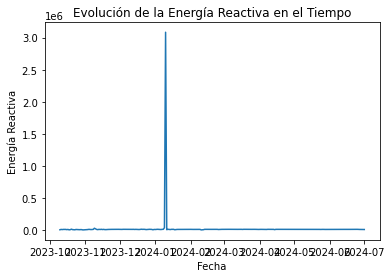

In [27]:

# Visualiza la serie temporal
plt.plot(data_day['date'], data_day['energia_reactiva'])
plt.title('Evolución de la Energía Reactiva en el Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Energía Reactiva')
plt.show()

El dato atípico es porque el sensor se desalibro

In [28]:
# identificando outliers
# Identifica el valor máximo de la energía reactiva
max_value_index = data_day['energia_reactiva'].idxmax()

# Obtén la fecha correspondiente al valor máximo
max_value_date = data_day.loc[max_value_index, 'date']

# Muestra la fecha del valor máximo
print(f"La fecha del valor máximo de energía reactiva es: {max_value_date}")

La fecha del valor máximo de energía reactiva es: 2024-01-10 00:00:00


In [29]:
data_day.iloc[max_value_index]

date                      2024-01-10 00:00:00
voltaje_ab                          323.72875
voltaje_bc                         323.639667
voltaje_ca                         323.721583
tension_media                       323.69675
potencia_activa                    171.600667
potencia_reactiva                     71.7065
potencia_aparente                     191.908
factor_potencia                        0.7205
corriente_a                        418.131583
corriente_b                        423.643083
corriente_c                         419.74725
corriente_media                       420.509
distorsion_media_total              125.97825
energia_activa                      1679608.1
energia_reactiva                    3084156.9
energia_aparente                    1612139.6
Name: 89, dtype: object

In [30]:
#reemplazando el valor

data_day.loc[max_value_index, 'energia_reactiva'] = data_day['energia_reactiva'].mean()

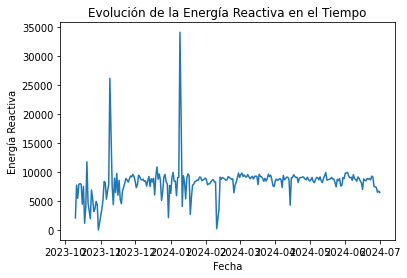

In [31]:


# Visualiza la serie temporal
plt.plot(data_day['date'], data_day['energia_reactiva'])
plt.title('Evolución de la Energía Reactiva en el Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Energía Reactiva')
plt.show()

In [32]:


# Realiza la prueba de Dickey-Fuller ADF en la columna 'energia_reactiva'
result = adfuller(data_day['energia_reactiva'])

# Muestra los resultados
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -10.131569191954382
p-value: 8.889662895465194e-18
Critical Values: {'1%': -3.4557539868570775, '5%': -2.8727214497041422, '10%': -2.572728476331361}


In [46]:
# como la serie es estacionaria
print(data_day['energia_reactiva'].iloc[0:262].mean())
print(data_day['energia_reactiva'].iloc[0:200].mean())
print(data_day['energia_reactiva'].iloc[0:100].mean())
print(data_day['energia_reactiva'].iloc[0:50].mean())
      

8399.30764669891
8322.240517175573
7971.778034351144
7154.52


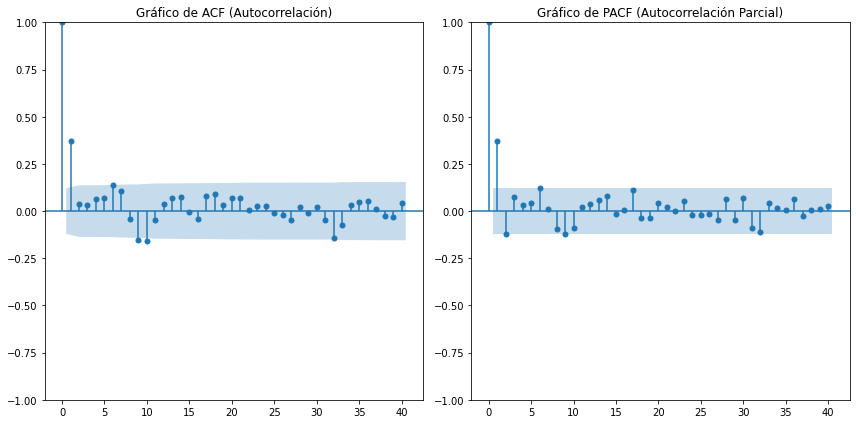

In [229]:
# Si la serie es estacionaria, puedes graficar directamente
# Energía reactiva
energia_reactiva = data_day['energia_reactiva']

# Graficar ACF y PACF
plt.figure(figsize=(12, 6))

# Gráfico de ACF para seleccionar q
plt.subplot(121)
plot_acf(energia_reactiva, ax=plt.gca(), lags=40)
plt.title('Gráfico de ACF (Autocorrelación)')

# Gráfico de PACF para seleccionar p
plt.subplot(122)
plot_pacf(energia_reactiva, ax=plt.gca(), lags=40)
plt.title('Gráfico de PACF (Autocorrelación Parcial)')

plt.tight_layout()
plt.show()

In [230]:
# Define los parámetros (p, d, q)
p = 1  # Cambia este valor basado en el PACF
d = 0  # La serie es estacionaria
q = 1  # Cambia este valor basado en el ACF

# Ajustar el modelo ARIMA
model = ARIMA(energia_reactiva, order=(p, d, q))
model_fit = model.fit()

# Imprimir resumen del modelo ajustado
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:       energia_reactiva   No. Observations:                  262
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2424.955
Date:                Wed, 09 Oct 2024   AIC                           4857.910
Time:                        20:54:48   BIC                           4872.184
Sample:                             0   HQIC                          4863.647
                                - 262                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8399.3076    307.352     27.328      0.000    7796.909    9001.707
ar.L1          0.0814      0.121      0.672      0.502      -0.156       0.319
ma.L1          0.3568      0.092      3.884      0.0

# describir los resultados de la tabla: 



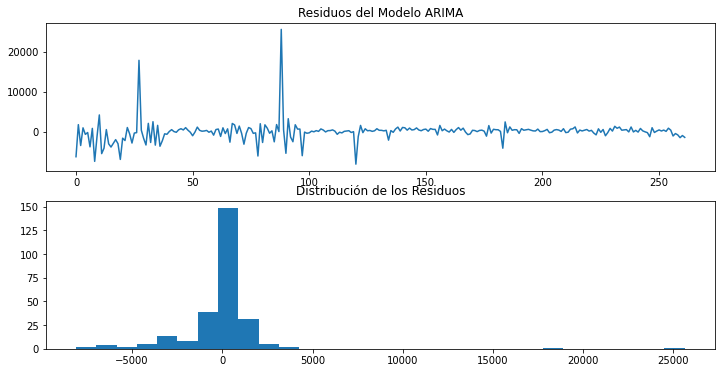

In [231]:
# Graficar residuos
residuals = model_fit.resid

plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(residuals)
plt.title('Residuos del Modelo ARIMA')

plt.subplot(212)
plt.hist(residuals, bins=30)
plt.title('Distribución de los Residuos')
plt.show()

In [232]:
# Realizar predicciones en el conjunto de datos
forecast = model_fit.forecast(steps=10)  # Predecir los próximos 10 puntos

# Mostrar predicciones
print(forecast)

262    7745.569757
263    8346.102011
264    8394.977394
265    8398.955204
266    8399.278945
267    8399.305293
268    8399.307438
269    8399.307612
270    8399.307626
271    8399.307627
Name: predicted_mean, dtype: float64


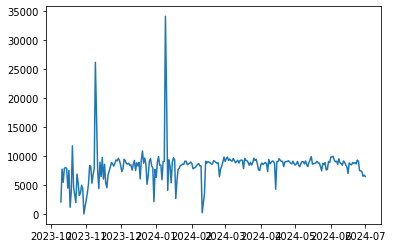

In [233]:
plt.plot(data_day["date"], energia_reactiva, label='Datos Originales')

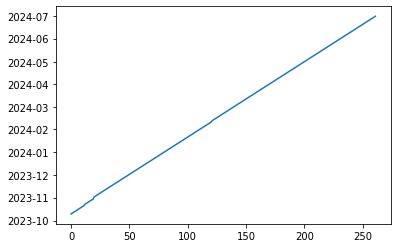

In [234]:
plt.plot(data_day["date"], )

In [235]:
# Predicciones dentro del rango de los datos
start = data_day.index[0]  # Fecha inicial de los datos
end = data_day.index[-1]    # Fecha final de los datos

# Realizar la predicción dentro de la muestra (en el rango de fechas existentes)
predictions_in_sample = model_fit.predict(start=start, end=end)

In [236]:
forecast = model_fit.forecast(steps=10)

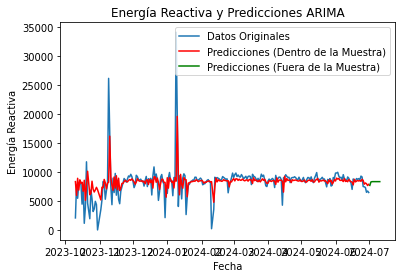

In [237]:
# Graficar los datos originales
plt.plot(data_day['date'], data_day['energia_reactiva'], label='Datos Originales')

# Graficar las predicciones dentro de la muestra
plt.plot(data_day['date'], predictions_in_sample, label='Predicciones (Dentro de la Muestra)', color='red')

# Si realizaste predicciones fuera de la muestra, las puedes graficar también
# Supongamos que el índice del forecast se extiende después del último índice de data_day
forecast_index = pd.date_range(start=data_day['date'].iloc[-1], periods=len(forecast)+1, freq='D')[1:]
plt.plot(forecast_index, forecast, label='Predicciones (Fuera de la Muestra)', color='green')

# Personalizar el gráfico
plt.title('Energía Reactiva y Predicciones ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Energía Reactiva')
plt.legend()
plt.show()

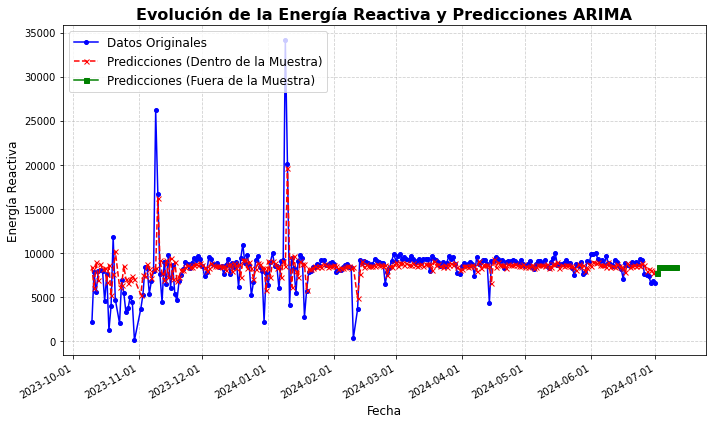

In [238]:


# Tamaño del gráfico
plt.figure(figsize=(10, 6))

# Graficar los datos originales
plt.plot(data_day['date'], data_day['energia_reactiva'], label='Datos Originales', color='blue', linestyle='-', marker='o', markersize=4)

# Graficar las predicciones dentro de la muestra
plt.plot(data_day['date'], predictions_in_sample, label='Predicciones (Dentro de la Muestra)', color='red', linestyle='--', marker='x', markersize=5)

# Graficar las predicciones fuera de la muestra (si las hay)
forecast_index = pd.date_range(start=data_day['date'].iloc[-1], periods=len(forecast)+1, freq='D')[1:]
plt.plot(forecast_index, forecast, label='Predicciones (Fuera de la Muestra)', color='green', linestyle='-', marker='s', markersize=5)

# Personalizar el gráfico

# Añadir una cuadrícula
plt.grid(True, linestyle='--', alpha=0.6)

# Añadir el título y etiquetas
plt.title('Evolución de la Energía Reactiva y Predicciones ARIMA', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Energía Reactiva', fontsize=12)

# Mejorar la legibilidad del eje X (Fechas)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Mostrar fechas cada mes
plt.gcf().autofmt_xdate()  # Rotar etiquetas de fecha para legibilidad

# Añadir leyenda
plt.legend(fontsize=12, loc='upper left')

# Mostrar el gráfico
plt.tight_layout()
plt.show()